# Wheat sowing classification along with wheat and non wheat classification

## Basic Characteristic check and preprocessing

In [123]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

In [124]:
df1 = pd.read_csv(r'data_files/Copy of NDVI Wheat MP 5 periods 10 Bands - Sheet1.csv')
df2 = pd.read_csv(r'data_files/Copy of NDVI Wheat MP 5 periods 10 Bands - Sheet2.csv')

In [125]:
wheat = pd.concat([df1, df2], axis=1)

In [126]:
wheat.head(2)

,0,1,2,3,4,5,6,7,8,9,Label,latitude,longitude,Dist
0,117,154,185,186,191,191,185,177,131,120,0,23.22102420000,75.54814340000,UJJAIN
1,118,153,172,182,189,181,173,157,124,118,0,22.74924340000,76.28596060000,DEWAS


In [127]:
wheat.rename({'0':'oct_2f', '1':'nov_1f', '2':'nov_2f', '3':'dec_1f', '4':'dec_2f', '5':'jan_1f', '6':'jan_2f', '7':'feb_1f', '8':'feb_2f', '9':'mar_1f', 'Label':'label', 'Dist':'district'}, axis=1, inplace=True)

In [128]:
wheat.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [129]:
wheat.head(2)

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,label,district
0,117,154,185,186,191,191,185,177,131,120,0,UJJAIN
1,118,153,172,182,189,181,173,157,124,118,0,DEWAS


In [130]:
xlsx = pd.ExcelFile('data_files/MP_crop_profiles.xlsx')
gram = pd.read_excel(xlsx, 'Gram')
mustard = pd.read_excel(xlsx, 'Mustard')
mustard1 = pd.read_excel(r'data_files/Mustard_GT_profiles_MP_30may23.xlsx')
pulses = pd.read_excel(xlsx, 'pulses')

In [131]:
mustard1.head(3)

,lat,long,Crop_Nam_1,STATE_NAME,DISTRICT,Oct_2FN,Nov_1FN,Nov_2FN,Dec_1FN,Dec_2FN,Jan_1FN,Jan_2FN,Feb_1Fn,Feb_2Fn,Mar_1Fn
0,24.031002,75.761473,2 Mustard,Madhya Pradesh,MANDSAUR,131,130,178,185,183,183,184,181,150,130
1,24.326160,75.020576,2 Mustard,Madhya Pradesh,MANDSAUR,118,130,174,190,189,187,182,160,127,125
2,25.300808,78.009660,2 Mustard,Madhya Pradesh,SHIVPURI,125,130,180,189,187,183,184,179,155,131


In [132]:
mustard1.drop(['lat', 'long', 'STATE_NAME'], axis=1, inplace=True)
mustard1.rename({'Crop_Nam_1':'label'}, axis=1, inplace=True)
mustard1.label = mustard1.label.apply(lambda row : row[2:])
mustard1.columns = ['label', 'district', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f']

In [133]:
pulses.head(2)

,label,district,Oct_2F,Nov_1F,Nov_2F,Dec_1F,Dec_2F,Jan_1F,Jan_2F,Feb_1F,Feb_2F,Mar_1F
0,Pulses,ALIRAJPUR,158,131,132,134,149,157,161,159,141,127
1,Pulses,ALIRAJPUR,156,134,134,128,143,160,158,161,157,140


In [134]:
for crop_data in [mustard, gram, pulses]:
    crop_data.columns = map(str.lower, crop_data.columns)

In [135]:
df = pd.concat([wheat, mustard, gram, pulses, mustard1], ignore_index=True)

In [136]:
df.shape[0]

19210

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19210 entries, 0 to 19209
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oct_2f    19210 non-null  object
 1   nov_1f    19210 non-null  object
 2   nov_2f    19210 non-null  object
 3   dec_1f    19210 non-null  object
 4   dec_2f    19210 non-null  object
 5   jan_1f    19210 non-null  object
 6   jan_2f    19210 non-null  object
 7   feb_1f    19210 non-null  object
 8   feb_2f    19210 non-null  object
 9   mar_1f    19210 non-null  object
 10  label     19210 non-null  object
 11  district  19210 non-null  object
dtypes: object(12)
memory usage: 1.8+ MB


In [138]:
def int_check(val):
    try:
        val = int(val)
    except:
        pass
    return val

In [139]:
df = df.drop(10906)

In [140]:
for i in df.columns[:10]:
    df[i] = df[i].astype(int)

In [141]:
df.district = df.district.astype(str)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19209 entries, 0 to 19209
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oct_2f    19209 non-null  int32 
 1   nov_1f    19209 non-null  int32 
 2   nov_2f    19209 non-null  int32 
 3   dec_1f    19209 non-null  int32 
 4   dec_2f    19209 non-null  int32 
 5   jan_1f    19209 non-null  int32 
 6   jan_2f    19209 non-null  int32 
 7   feb_1f    19209 non-null  int32 
 8   feb_2f    19209 non-null  int32 
 9   mar_1f    19209 non-null  int32 
 10  label     19209 non-null  object
 11  district  19209 non-null  object
dtypes: int32(10), object(2)
memory usage: 1.2+ MB


In [143]:
df.describe()

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f
count,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000
mean,144.435681,129.791504,130.561351,145.213650,169.505076,180.495653,183.448800,185.414858,179.702327,161.724348
std,17.304535,13.316600,14.430981,20.828144,16.231467,13.577124,6.503395,6.665503,13.541293,22.040497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130.000000,120.000000,122.000000,128.000000,158.000000,176.000000,180.000000,183.000000,176.000000,144.000000
50%,142.000000,126.000000,126.000000,138.000000,173.000000,183.000000,184.000000,187.000000,184.000000,169.000000
75%,157.000000,136.000000,133.000000,162.000000,183.000000,187.000000,188.000000,189.000000,188.000000,180.000000
max,200.000000,195.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000


In [144]:
# No null values
df.isna().sum().sum()

0

In [145]:
df.label.value_counts()

2          7175
3          5558
1          3637
Mustard    2048
Gram        351
4           245
Pulses      101
0            94
Name: label, dtype: int64

In [146]:
df['label'] = df.label.apply(lambda row : 5 if type(row) != int else row)

In [147]:
df.label.value_counts()

2    7175
3    5558
1    3637
5    2500
4     245
0      94
Name: label, dtype: int64

## Train-Test Split

In [148]:
df.drop('district', axis=1, inplace=True)

In [149]:
df.head(2)

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,label
0,117,154,185,186,191,191,185,177,131,120,0
1,118,153,172,182,189,181,173,157,124,118,0


In [150]:
# 60-20-20 split

train_val, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train, val = train_test_split(train_val, test_size=0.25, random_state=42, stratify=train_val['label'])

In [151]:
train.label.value_counts(normalize=True), test.label.value_counts(normalize=True), val.label.value_counts(normalize=True)

(2    0.373536
 3    0.289284
 1    0.189414
 5    0.130152
 4    0.012755
 0    0.004859
 Name: label, dtype: float64,
 2    0.373503
 3    0.289433
 1    0.189224
 5    0.130141
 4    0.012754
 0    0.004945
 Name: label, dtype: float64,
 2    0.373503
 3    0.289433
 1    0.189224
 5    0.130141
 4    0.012754
 0    0.004945
 Name: label, dtype: float64)

## Data Preprocessing

### Target Encoding district column

In [152]:
# import category_encoders.target_encoder as te

# label_ohe = pd.get_dummies(train.label)

# for label in label_ohe.columns:
#     encoder = te.TargetEncoder()
    
#     train[f'district_{label}'] = encoder.fit_transform(train['district'], label_ohe[label])
#     test[f'district_{label}'] = encoder.transform(test['district'])
#     val[f'district_{label}'] = encoder.transform(val['district'])

### Heat Map

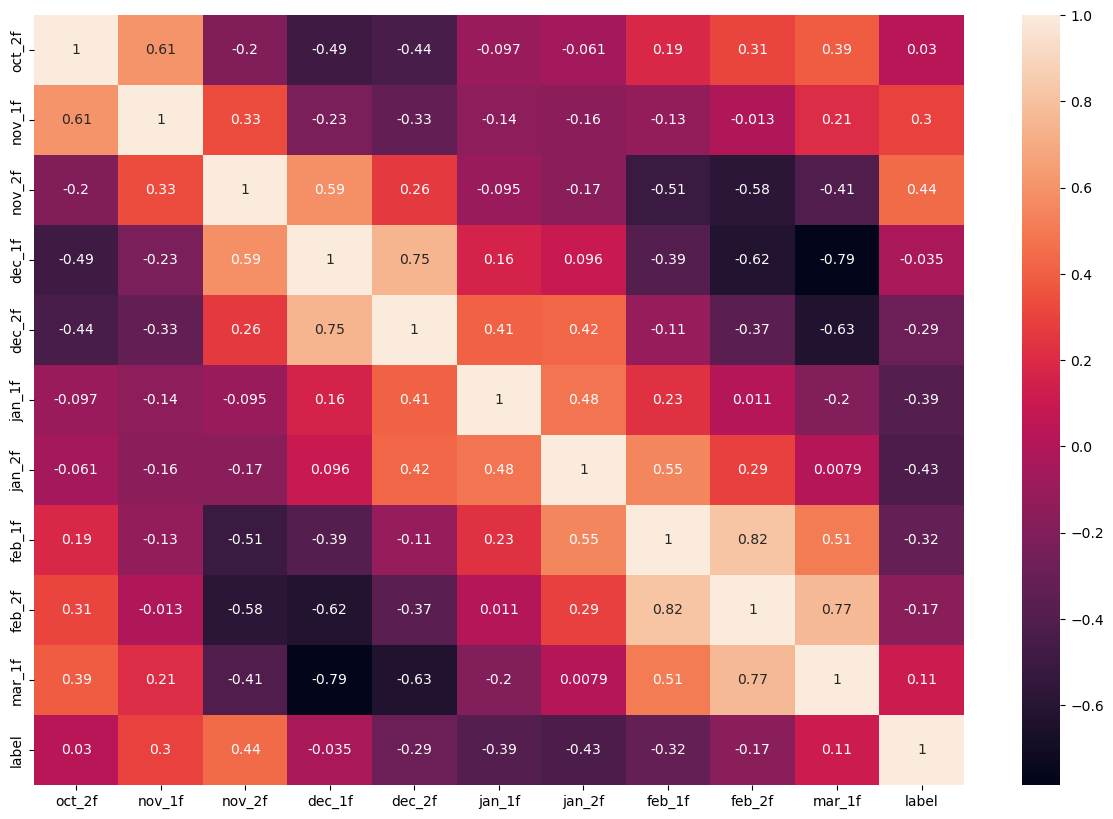

In [153]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot=True)
plt.show()

### Standardising the entire dataset

In [154]:
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']
X_val = val.drop('label', axis=1)
y_val = val['label']

scaler = StandardScaler()

X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_val=pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

In [155]:
import pickle

pickle.dump(scaler, open(r'models/Multiclass_StandardScaler_1.1', 'wb'))

## Modelling

- Labels indicate the sowing season = 
    0:wheat-oct_2f, 1:wheat-nov_1f, 2:wheat-nov_2f, 3:wheat-dec_1f, 
    4:wheat-dec_2f, 5:non-wheat

- Will be training my model on the F1 score

In [156]:
#Imbalance observed

y_train.value_counts()

2    4305
3    3334
1    2183
5    1500
4     147
0      56
Name: label, dtype: int64

In [157]:
fort_nights = list(train.loc[:, 'oct_2f':'mar_1f'].columns)

In [158]:
pd.Series(compute_sample_weight(class_weight='balanced',y=train['label'])).value_counts()

0.446187     4305
0.576135     3334
0.879905     2183
1.280556     1500
13.066893     147
34.300595      56
dtype: int64

In [159]:
params = {'n_estimators':np.arange(5,55,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,6,1)}

sample_weights = compute_sample_weight(class_weight='balanced',y=train['label'])

param_grid = list(ParameterGrid(params))

i = 0

max_recall_scores = []

while (i + 4) <= len(fort_nights):
    recall_scores = []
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        if i == 0:
            drop_cols = []
        else:
            drop_cols = fort_nights[-i:]
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train, sample_weight=sample_weights)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1,2,3,4,5])
        recall_scores.append(recall[-1])
    max_recall_scores.append([max(recall_scores), param_grid[np.argmax(recall_scores)]])
    i += 1

print('Done!!')

Done!!


In [160]:
max_recall_scores = np.array(max_recall_scores)
max_recall_scores

array([[0.914,
        {'learning_rate': 0.35000000000000003, 'max_depth': 5, 'n_estimators': 40}],
       [0.896,
        {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 45}],
       [0.874,
        {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40}],
       [0.858,
        {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 50}],
       [0.846,
        {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 50}],
       [0.77,
        {'learning_rate': 0.45, 'max_depth': 5, 'n_estimators': 50}],
       [0.696,
        {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 35}]],
      dtype=object)

In [161]:
from copy import deepcopy

test_recall_scores = []
confusion_matrices = []
test_dfs = []

for i in range(len(max_recall_scores)):
    best_classifier = XGBClassifier(**max_recall_scores[i][1])
    if i == 0:
            drop_cols = []
    else:
            drop_cols = fort_nights[-i:]
    temp_X_train = X_train.drop(drop_cols, axis=1)
    temp_X_test = X_test.drop(drop_cols, axis=1)
    best_classifier.fit(temp_X_train, y_train, sample_weight=sample_weights)
    pickle.dump(best_classifier, open(r'models/Multiclass_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    precision, recall, f1score, support = score(y_test, test_pred, labels=[0,1,2,3,4,5])
    test_recall_scores.append([recall[2], recall[-1]])
    confusion_matrices.append(pd.DataFrame(confusion_matrix(y_test, test_pred), 
                         columns=['Wheat-Oct_2f', 'Wheat-Nov_1f','Wheat-Nov_2f','Wheat-Dec_1f','Wheat-Dec_2f', 'Non_Wheat'], 
                         index=['Wheat-Oct_2f', 'Wheat-Nov_1f','Wheat-Nov_2f','Wheat-Dec_1f','Wheat-Dec_2f', 'Non_Wheat']))
    df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_Wheat-Oct_2f', 'incorr_Wheat-Nov_1f', 'incorr_Wheat-Nov_2f', 'incorr_Wheat-Dec_1f','incorr_Wheat-Dec_2f', 'incorr_Non_Wheat']
    df1 = pd.concat([df1, temp_df], axis=1)
    test_dfs.append(df1)
    
    print(test_recall_scores[-1])

[0.9902439024390244, 0.924]
[0.9853658536585366, 0.904]
[0.9867595818815331, 0.888]
[0.9895470383275261, 0.876]
[0.9860627177700348, 0.866]
[0.9853658536585366, 0.764]
[0.9714285714285714, 0.69]


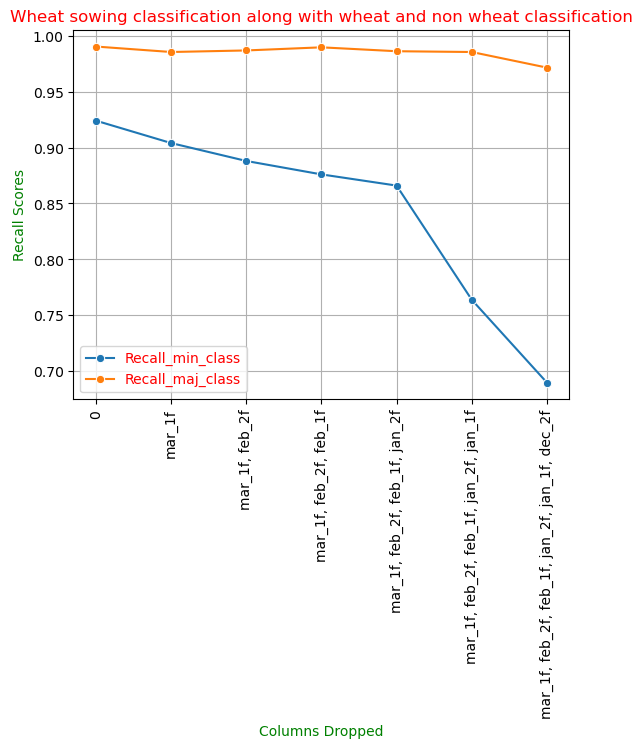

In [162]:
sns.lineplot(y=np.array(test_recall_scores)[:,1], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_min_class', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,0], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_maj_class', marker="o")
plt.xlabel('Columns Dropped')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat sowing classification along with wheat and non wheat classification')
plt.grid()
plt.show()

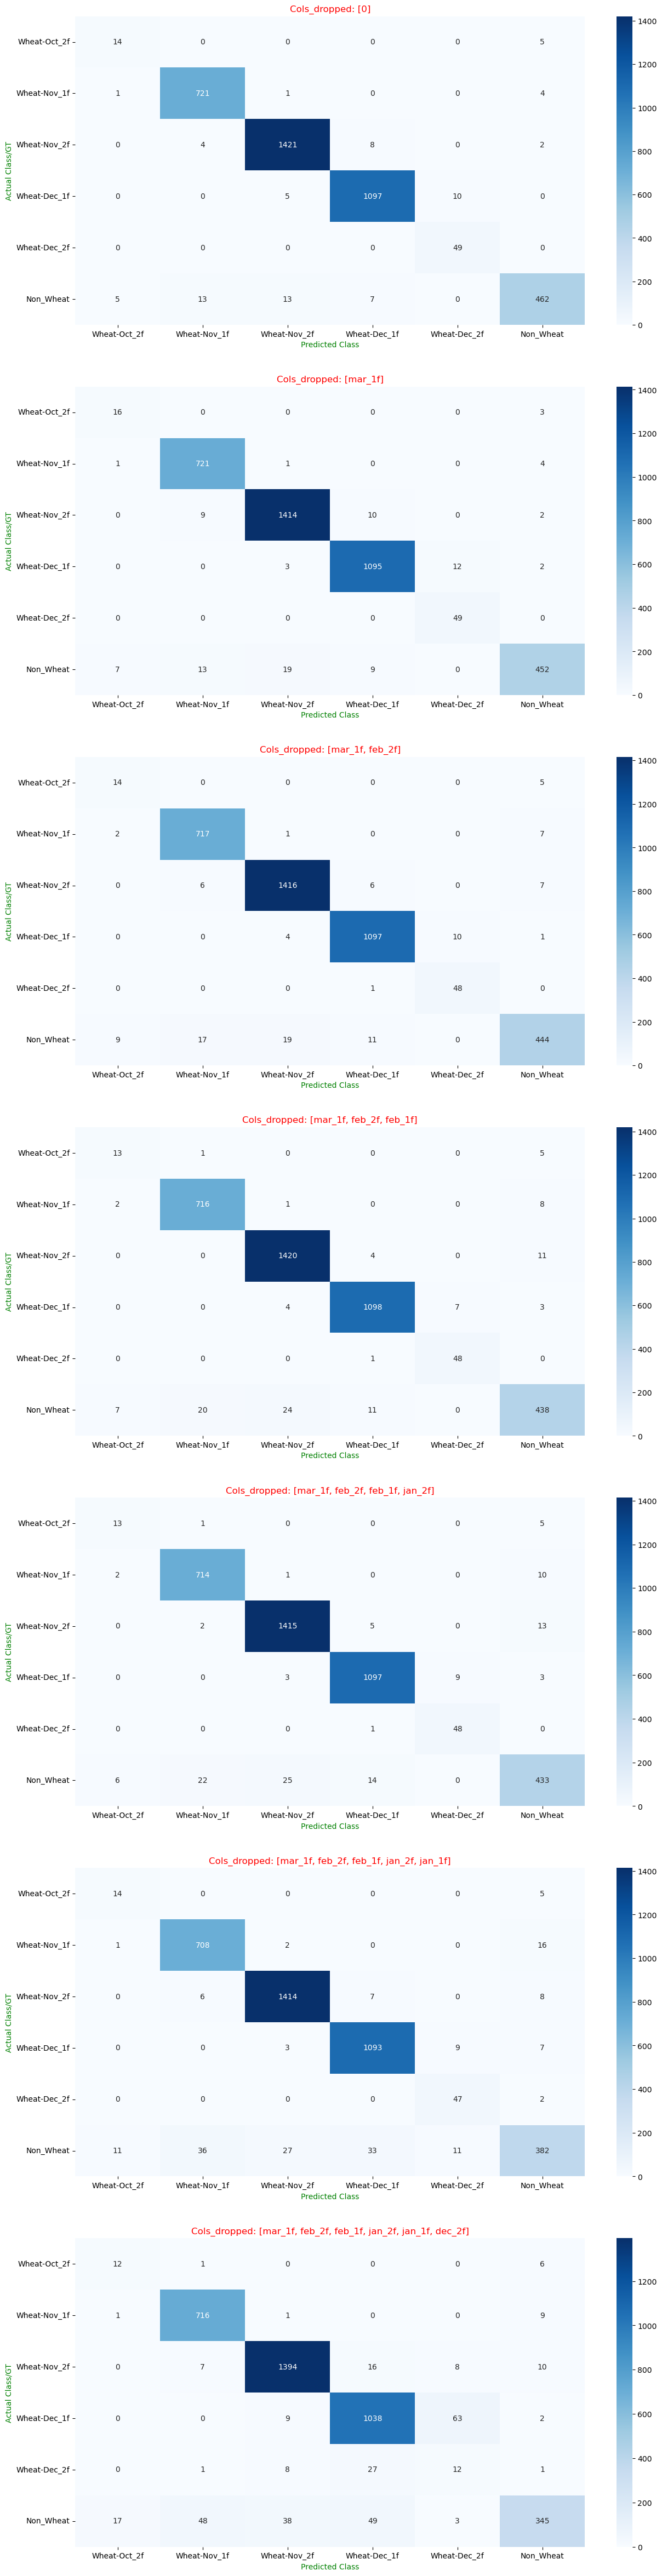

In [163]:
plt.figure(figsize=(15,60))
columns_dropped = ['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f']
for i in range(len(confusion_matrices)):
    plt.subplot(7,1,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Cols_dropped: [{columns_dropped[i]}]')
    plt.rcParams.update({'text.color': "red",
                     'axes.labelcolor': "green"})
plt.show()